# SIFT图像拼接 

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### 对三张图像进行拼接

In [2]:
img_list = ['imgs/stitch/3.jpg', 'imgs/stitch/2.jpg', 'imgs/stitch/1.jpg']

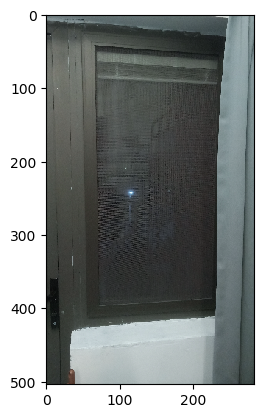

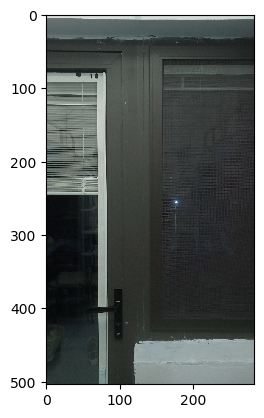

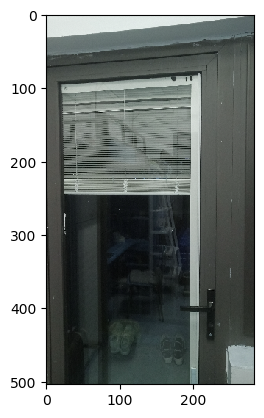

In [3]:
def cvshow(img, window_name='img'):
    cv2.imshow(window_name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def readAndProcess(img_path):
    img = cv2.imread(img_path)
    # 手机拍摄的分辨率很高, 需要降低一部分
    img = cv2.resize(img, (img.shape[1]//8, img.shape[0]//8))
    plt.imshow(img)
    plt.show()
    return img

imgs = [readAndProcess(path) for path in img_list]

In [4]:
# 拼接两幅图
def stitch(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # 直方图均衡
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray1 = clahe.apply(gray1)
    gray2 = clahe.apply(gray2)
    # cvshow(gray1)

    sift = cv2.SIFT_create()
    # 特征点提取
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.76 * n.distance:
            good_matches.append(m)
            
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(match_img)
    plt.show()
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    result = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    # 防止边界溢出, 加一些边框
    disVertical = abs(img2.shape[0] - result.shape[0])
    disHorizontal = abs(img2.shape[1] - result.shape[1])
    result = cv2.copyMakeBorder(result, disVertical, disVertical, 0, disHorizontal, cv2.BORDER_CONSTANT, None, [0,0,0])

    # 处理接缝, 如果已经配准, 两幅图的接缝一般来自于亮度不同
    co_img2 = np.zeros_like(result)
    co_img2[0:img2.shape[0], 0:img2.shape[1]] = img2
    mask = co_img2 > result
    # 此处直接取两图重合部分中较亮的位置
    # 这样的好处是一方面直接忽略了黑色边框, 另一方面, 速度很快, 方便处理
    # 直接取最亮的像素, 会不会影响图像信息?
    # 一般不会, 如果会, 那说明没配准, 属于配准问题, 和这种融合方法关系不大
    final = (co_img2 * mask + result * (1 - mask)).astype(np.uint8)
    return final



#### 流程: 拼接完两幅图像后, 使用拼接结果来继续拼接第三幅图

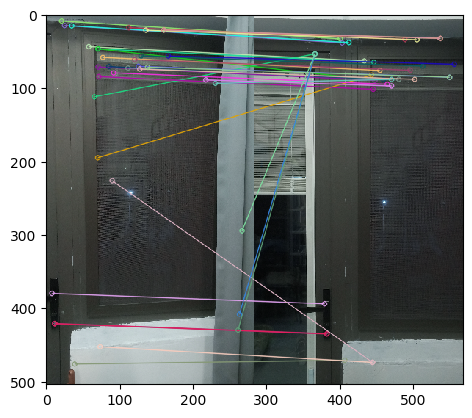

stitched 2 images


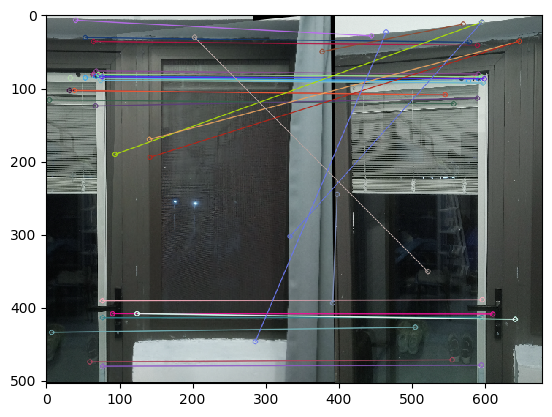

stitched 3 images


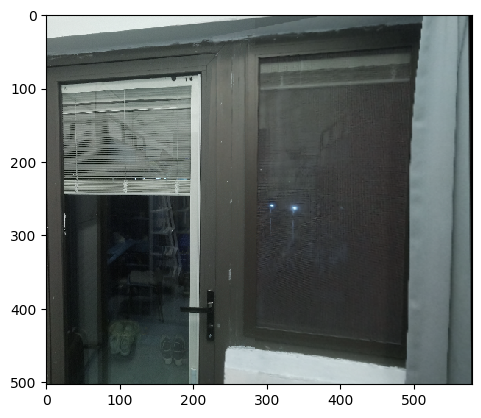

done


In [5]:
for idx, img in enumerate(imgs):
    if idx == 0:
        base_img = img
        continue
    res = stitch(base_img, img)
    # 去除黑色无效区域
    nonz = np.nonzero(res)
    base_img = res[np.min(nonz[0]):np.max(nonz[0]), np.min(nonz[1]):np.max(nonz[1])]
    print("stitched", idx + 1, "images")

plt.imshow(base_img)
plt.show()
print('done')
